### Coffee Roasting With Tensorflow
Numpy - numerical computing <br>
Tensorflow - handles large datasets and can be used to train models on both CPU & GPU

In [6]:
# Main-Setup
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Libs-Setup
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
import tensorflow as tf
from lab_utils_common import dlc
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

### Checking DataSet

(200, 2) (200, 1)


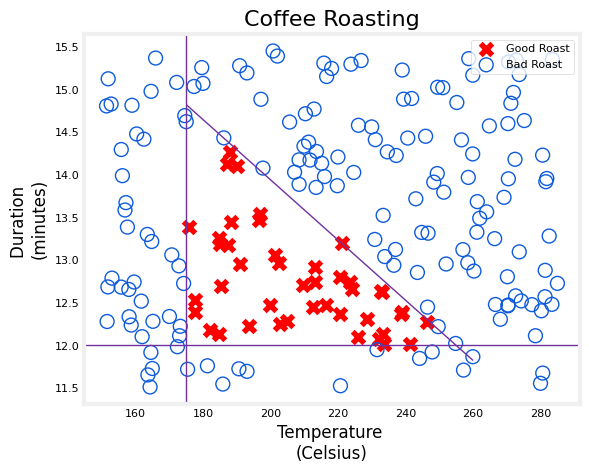

In [4]:
X,Y = load_coffee_data()
print(X.shape, Y.shape)
plt_roast(X,Y)

### Normalization
'adapt' the data. This learns the mean and variance of the data set and saves the values internally.

In [7]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis = -1)
norm_l.adapt(X)
Xn = norm_l(X)
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


tile/copy our data to increase the training set size and reduce the number of training epochs

In [17]:
Xt = np.tile(Xn, (1000,1))
Yt = np.tile(Y, (1000,1))
print(Xt.shape,Yt.shape)

(200000, 2) (200000, 1)


### Model
<img src="roastingNetwork.png" width="200"/>

In [18]:
tf.random.set_seed(1234) # applied to achieve consistent results
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(3, activation='sigmoid', name='layer1'),
        tf.keras.layers.Dense(1, activation='sigmoid', name='layer2')
    ]
)

In [19]:
model.summary() # To check network's details and to check if everything is fine

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 3)                 9         
                                                                 
 layer2 (Dense)              (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


----------

The weights $W$ should be of size (number of features in input, number of units in the layer) while the bias $b$ size should match the number of units in the layer:
- In the first layer with 3 units, we expect W to have a size of (2,3) and $b$ should have 3 elements.
- In the second layer with 1 unit, we expect W to have a size of (3,1) and $b$ should have 1 element.

In [20]:
L1_num_params = 2 * 3 + 3
L2_num_params = 3 * 1 + 1
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params)

L1 params =  9 , L2 params =  4


In [21]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(2, 3):
 [[ 0.29 -0.62  0.38]
 [-0.82  0.42  0.79]] 
b1(3,): [0. 0. 0.]
W2(3, 1):
 [[ 0.29]
 [-1.12]
 [ 0.31]] 
b2(1,): [0.]


In [22]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)

model.fit(
    Xt,Yt,            
    epochs=10,
)

Epoch 1/10
6250/6250 [==============================] - 17s 2ms/step - loss: 0.2633
Epoch 2/10
6250/6250 [==============================] - 16s 2ms/step - loss: 0.1340
Epoch 3/10
6250/6250 [==============================] - 15s 2ms/step - loss: 0.1240
Epoch 4/10
6250/6250 [==============================] - 15s 2ms/step - loss: 0.1158
Epoch 5/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.1100
Epoch 6/10
6250/6250 [==============================] - 13s 2ms/step - loss: 0.0590
Epoch 7/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0161
Epoch 8/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0105
Epoch 9/10
6250/6250 [==============================] - 11s 2ms/step - loss: 0.0075
Epoch 10/10
6250/6250 [==============================] - 13s 2ms/step - loss: 0.0054


In [23]:
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print("W1:\n", W1, "\nb1:", b1)
print("W2:\n", W2, "\nb2:", b2)

W1:
 [[-18.16  -9.79   0.09]
 [-15.13  -0.18  -8.34]] 
b1: [ -2.52 -10.67 -10.52]
W2:
 [[ 27.78]
 [-38.06]
 [-34.25]] 
b2: [-8.18]


Next, we will load some saved weights from a previous training run. This is so that this notebook remains robust to changes in Tensorflow over time. Different training runs can produce somewhat different results and the discussion below applies to a particular solution. Feel free to re-run the notebook with this cell commented out to see the difference.

In [24]:
W1 = np.array([
    [-8.94,  0.29, 12.89],
    [-0.17, -7.34, 10.79]] )
b1 = np.array([-9.87, -9.28,  1.01])
W2 = np.array([
    [-31.38],
    [-27.86],
    [-32.79]])
b2 = np.array([15.54])
model.get_layer("layer1").set_weights([W1,b1])
model.get_layer("layer2").set_weights([W2,b2])

### Predictions
Once you have a trained model, you can then use it to make predictions. Recall that the output of our model is a probability. In this case, the probability of a good roast. To make a decision, one must apply the probability to a threshold. In this case, we will use 0.5

Let's start by creating input data. The model is expecting one or more examples where examples are in the rows of matrix. In this case, we have two features so the matrix will be (m,2) where m is the number of examples.
Recall, we have normalized the input features so we must normalize our test data as well.   
To make a prediction, you apply the `predict` method.

In [26]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)

1/1 [==============================] - 0s 19ms/step
predictions = 
 [[9.63e-01]
 [3.03e-08]]


In [28]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


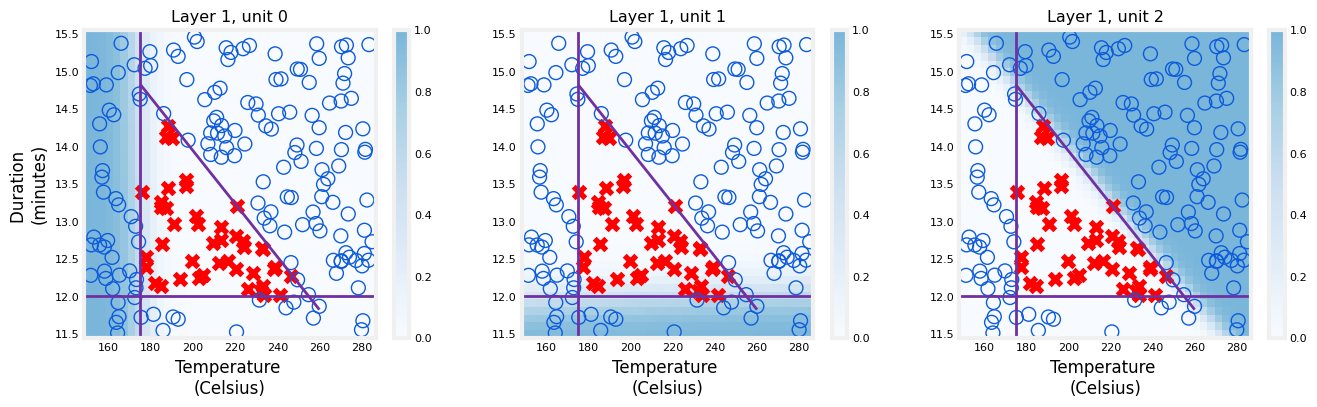

In [29]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)

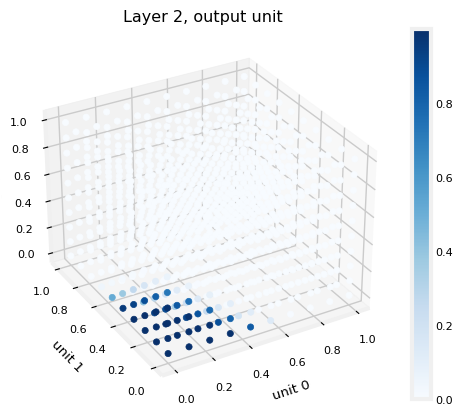

In [30]:
plt_output_unit(W2,b2)

In [31]:
netf= lambda x : model.predict(norm_l(x))
plt_network(X,Y,netf)

1/1 [==============================] - 0s 17ms/step
